# A* Pathfinding: Modelo de IA vs. Heurística Clásica

Este cuaderno demuestra y compara dos enfoques para el algoritmo de búsqueda de rutas A*:

1.  **A* con Heurística de Distancia Manhattan:** Un método clásico, rápido y confiable que garantiza la ruta más corta en una cuadrícula. Su desventaja es que no "ve" los obstáculos y puede explorar muchas rutas sin salida antes de encontrar la solución.
2.  **A* con un Modelo de IA (CNN):** Un enfoque moderno donde una pequeña red neuronal convolucional (CNN) es entrenada en vivo sobre el laberinto específico que diseñemos. El modelo aprende a predecir la distancia real hasta el objetivo, teniendo en cuenta los obstáculos.

El objetivo es observar cómo un modelo entrenado puede guiar la búsqueda de A* de manera mucho más eficiente, reduciendo drásticamente el número de "nodos expandidos" (celdas exploradas).

In [1]:
import time
from collections import deque
import heapq
from typing import Tuple, List, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

TRAINING_EPOCHS = 150
LEARNING_RATE = 0.001

## 1. Definición del Modelo de IA y Algoritmos A*

Primero, definimos las clases principales de nuestra aplicación:
*   `HeuristicCNN`: La arquitectura de la red neuronal que aprenderá la heurística.
*   `AStar`: La clase base para el algoritmo A*.
*   `AStarDeepLearning`: Una subclase que usa el modelo de IA para su heurística.
*   `AStarManhattan`: Una subclase que usa la distancia Manhattan.

In [2]:
class HeuristicCNN(nn.Module):
    def __init__(self):
        super(HeuristicCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.conv3(x)
        return x

class AStar:
    def __init__(self):
        self.nodes_expanded = 0

    def find_path(self, grid: np.ndarray, start: Tuple[int, int], goal: Tuple[int, int]) -> Optional[List[Tuple[int, int]]]:
        self.nodes_expanded = 0
        heuristic_map = self.get_heuristic(grid, goal)
        rows, cols = grid.shape
        open_set = [(0, start)]
        came_from = {}
        g_score = np.full((rows, cols), float('inf'))
        g_score[start] = 0
        f_score = np.full((rows, cols), float('inf'))
        f_score[start] = heuristic_map[start]

        while open_set:
            _, current = heapq.heappop(open_set)
            self.nodes_expanded += 1

            if current == goal:
                path = []
                while current in came_from:
                    path.append(current)
                    current = came_from[current]
                path.append(start)
                return path[::-1]

            for dr, dc in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                neighbor = (current[0] + dr, current[1] + dc)
                if 0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols and grid[neighbor] == 0:
                    tentative_g_score = g_score[current] + 1
                    if tentative_g_score < g_score[neighbor]:
                        came_from[neighbor] = current
                        g_score[neighbor] = tentative_g_score
                        f_score[neighbor] = tentative_g_score + heuristic_map[neighbor]
                        heapq.heappush(open_set, (f_score[neighbor], neighbor))
        return None

    def get_heuristic(self, grid: np.ndarray, goal: Tuple[int, int]) -> np.ndarray:
        raise NotImplementedError

class AStarDeepLearning(AStar):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model
        self.model.eval()

    def get_heuristic(self, grid: np.ndarray, goal: Tuple[int, int]) -> np.ndarray:
        grid_tensor = torch.from_numpy(grid).unsqueeze(0).unsqueeze(0).float()
        with torch.no_grad():
            heuristic_map = self.model(grid_tensor).squeeze().numpy()
        return heuristic_map

class AStarManhattan(AStar):
    def get_heuristic(self, grid: np.ndarray, goal: Tuple[int, int]) -> np.ndarray:
        height, width = grid.shape
        y, x = np.mgrid[0:height, 0:width]
        return np.abs(y - goal[0]) + np.abs(x - goal[1])

## 2. Funciones de Soporte

Estas funciones se encargan de la lógica principal:
*   `generate_target_heuristic`: Crea el "mapa de heurística perfecto" para un laberinto dado, que servirá como la verdad fundamental (ground truth) para entrenar el modelo.
*   `train_heuristic_model`: Contiene el bucle de entrenamiento del modelo de PyTorch.
*   `visualize_comparison`: Una función que usa Matplotlib para dibujar los resultados.

In [3]:
def generate_target_heuristic(grid: np.ndarray, goal: Tuple[int, int]) -> np.ndarray:
    rows, cols = grid.shape
    target_heuristic = np.full((rows, cols), float('inf'))
    q = deque([(goal, 0)])
    target_heuristic[goal] = 0
    visited = {goal}
    while q:
        (r, c), cost = q.popleft()
        for dr, dc in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < rows and 0 <= nc < cols and grid[nr, nc] == 0 and (nr, nc) not in visited:
                visited.add((nr, nc))
                target_heuristic[nr, nc] = cost + 1
                q.append(((nr, nc), cost + 1))
    return target_heuristic

def train_heuristic_model(grid: np.ndarray, goal: Tuple[int, int]) -> HeuristicCNN:
    target_heuristic_np = generate_target_heuristic(grid, goal)
    model = HeuristicCNN()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.MSELoss()
    grid_tensor = torch.from_numpy(grid).unsqueeze(0).unsqueeze(0).float()
    target_tensor = torch.from_numpy(target_heuristic_np).unsqueeze(0).unsqueeze(0).float()
    mask = ~torch.isinf(target_tensor)
    
    print(f"Entrenando modelo durante {TRAINING_EPOCHS} épocas...")
    for epoch in range(TRAINING_EPOCHS):
        optimizer.zero_grad()
        predicted_tensor = model(grid_tensor)
        loss = loss_fn(predicted_tensor[mask], target_tensor[mask])
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 50 == 0:
            print(f"  Época {epoch+1}/{TRAINING_EPOCHS}, Pérdida: {loss.item():.4f}")
    
    print("Entrenamiento completado.")
    return model

def visualize_comparison(grid, start, goal, path_dl, path_manhattan):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    paths = {'Modelo de IA': (ax1, path_dl), 'Distancia Manhattan': (ax2, path_manhattan)}
    
    for title, (ax, path) in paths.items():
        # Dibuja la cuadrícula: 0=blanco, 1=negro (muro)
        ax.imshow(grid, cmap='Greys', interpolation='nearest')
        
        # Dibuja la ruta si se encontró
        if path:
            path_rows, path_cols = zip(*path)
            ax.plot(path_cols, path_rows, color='yellow', linewidth=2, label='Ruta')
            
        # Dibuja el inicio (verde) y el objetivo (rojo)
        ax.plot(start[1], start[0], 'go', markersize=10, label='Inicio')
        ax.plot(goal[1], goal[0], 'ro', markersize=10, label='Objetivo')
        
        ax.set_title(title)
        ax.legend()
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.tight_layout()
    plt.show()

## 3. ¡Diseña tu Laberinto!

A diferencia de la aplicación web, aquí defines el laberinto editando directamente un array de NumPy.

*   `0` representa un camino libre.
*   `1` representa un muro u obstáculo.

**¡Experimenta!** Modifica el array `numpy_grid` para crear tus propios desafíos. Puedes cambiar el tamaño, añadir más muros o crear pasillos complejos.

In [4]:
numpy_grid = np.array([
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
    [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
    [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1],
    [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0],
    [0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
    [0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
    [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
])

rows, cols = numpy_grid.shape
start_pos = (0, 0)
goal_pos = (rows - 1, cols - 1)

## 4. Ejecución y Comparación

Esta es la celda principal. Al ejecutarla, ocurrirá lo siguiente:
1.  El modelo de IA será entrenado desde cero usando el laberinto que diseñaste.
2.  Se instanciarán ambos algoritmos A* (el entrenado y el de Manhattan).
3.  Cada algoritmo buscará una ruta de inicio a fin.
4.  Se medirán y mostrarán las estadísticas de rendimiento (nodos expandidos, longitud de la ruta y tiempo de ejecución).
5.  Finalmente, se generará una visualización de los resultados.

Entrenando modelo durante 150 épocas...
  Época 50/150, Pérdida: 79.6508
  Época 100/150, Pérdida: 45.5988
  Época 150/150, Pérdida: 29.2717
Entrenamiento completado.

--- Resultados de la Comparación ---

Método: Modelo de IA Entrenado
  Nodos Expandidos: 59
  Longitud de Ruta: 30
  Tiempo de Búsqueda: 0.54 ms

Método: Distancia Manhattan
  Nodos Expandidos: 41
  Longitud de Ruta: 30
  Tiempo de Búsqueda: 0.27 ms
------------------------------------



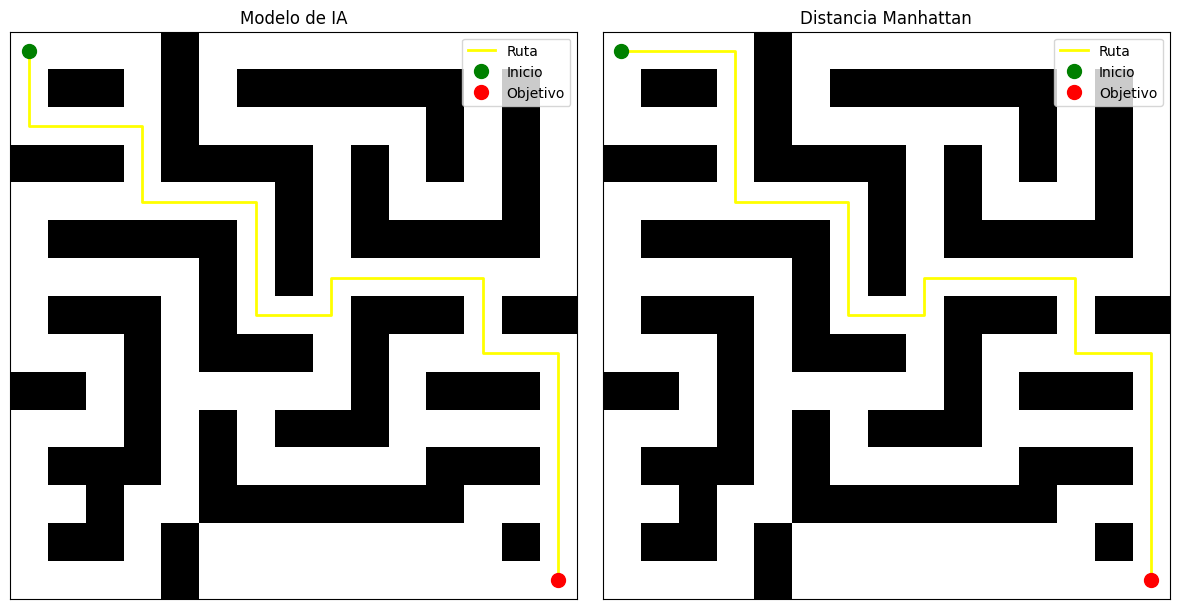

In [5]:
trained_model = train_heuristic_model(numpy_grid, goal_pos)

a_star_dl = AStarDeepLearning(trained_model)
a_star_manhattan = AStarManhattan()

start_time_dl = time.perf_counter()
path_dl = a_star_dl.find_path(numpy_grid, start_pos, goal_pos)
end_time_dl = time.perf_counter()
time_dl_ms = (end_time_dl - start_time_dl) * 1000

start_time_manhattan = time.perf_counter()
path_manhattan = a_star_manhattan.find_path(numpy_grid, start_pos, goal_pos)
end_time_manhattan = time.perf_counter()
time_manhattan_ms = (end_time_manhattan - start_time_manhattan) * 1000

print("\n--- Resultados de la Comparación ---")
print("\nMétodo: Modelo de IA Entrenado")
print(f"  Nodos Expandidos: {a_star_dl.nodes_expanded}")
print(f"  Longitud de Ruta: {len(path_dl) - 1 if path_dl else 'N/D'}")
print(f"  Tiempo de Búsqueda: {time_dl_ms:.2f} ms")

print("\nMétodo: Distancia Manhattan")
print(f"  Nodos Expandidos: {a_star_manhattan.nodes_expanded}")
print(f"  Longitud de Ruta: {len(path_manhattan) - 1 if path_manhattan else 'N/D'}")
print(f"  Tiempo de Búsqueda: {time_manhattan_ms:.2f} ms")
print("------------------------------------\n")


visualize_comparison(numpy_grid, start_pos, goal_pos, path_dl, path_manhattan)